In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from tensorflow.keras.layers import Layer, Dense, Lambda, dot, Activation, concatenate

In [2]:
%matplotlib inline

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [48]:
dfstocks = pd.read_csv('../../data/S&Pfinancedata2020.csv',parse_dates = True)
dftweets = pd.read_csv('../../data/stocktwitsprocessed.csv', parse_dates = True)

rowsdifference = dfstocks.iloc[:, 5]
dfstocks['Difference'] = rowsdifference.diff()
dfstocks['Date'] = pd.to_datetime(dfstocks['Date'])
dfstocks['Difference'].iloc[0] = 0
dftweets['date'] = pd.to_datetime(dftweets['date'])
dftweets['date'] = pd.to_datetime(dftweets['date'].dt.date)
dftweets = dftweets.groupby(dftweets['date'], as_index = False ).mean().sort_values('compound', ascending= True).reset_index()
dftweets.sort_values('date', inplace=True, ascending=True)
rowsdiff2 = dftweets['compound']
#dfstocks.set_index('Date').diff()
rowsdiff2.diff()
dftweets['Differencetweets'] = rowsdiff2
dftweets['Differencetweets'].iloc[0] = 0


merged = pd.merge(left=dftweets, left_on='date',
         right=dfstocks, right_on='Date')
merged_sim  = merged[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','compound','Close']]
#merged = merged[1:]

merged_sim.head()

,Open,High,Low,Adj Close,Volume,compound,Close
0,3205.080078,3235.320068,3149.429932,3155.219971,4890780000,0.014015,3155.219971
1,3141.110107,3200.949951,3127.659912,3197.520020,4476170000,0.029647,3197.520020
2,3225.979980,3238.280029,3200.760010,3226.560059,4669760000,0.022970,3226.560059
3,3208.360107,3220.389893,3198.590088,3215.570068,3961230000,0.020305,3215.570068
4,3224.209961,3233.520020,3205.649902,3224.729980,3993830000,0.085047,3224.729980


In [49]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [50]:
#https://github.com/philipperemy/keras-attention-mechanism
class Attention(Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __call__(self, hidden_states):
        hidden_size = int(hidden_states.shape[2])
        score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
        score = dot([score_first_part, h_t], [2, 1], name='attention_score')
        attention_weights = Activation('softmax', name='attention_weight')(score)
        context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
        pre_activation = concatenate([context_vector, h_t], name='attention_output')
        attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
        return attention_vector

# SA_LSTM with Attention

In [51]:
merged_sim  = merged[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','compound','Close']]
train_size = int(len(merged_sim) * 0.67)
test_size = len(merged_sim) - train_size
train, test = merged_sim.iloc[0:train_size], merged_sim.iloc[train_size:len(merged_sim)]
print(len(train), len(test))

73 37


In [52]:
from sklearn.preprocessing import RobustScaler

f_columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume','compound']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['Close']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['Close'] = cnt_transformer.transform(train[['Close']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['Close'] = cnt_transformer.transform(test[['Close']])

In [53]:
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

print(X_train.shape, y_train.shape)

(72, 1, 7) (72,)


In [54]:
modelSAA = keras.Sequential()
modelSAA.add(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2]),
      return_sequences = True
    )
)
modelSAA.add(keras.layers.Dropout(rate=0.2))
modelSAA.add(Attention())
modelSAA.add(keras.layers.Dense(units=1))
modelSAA.compile(loss='mean_squared_error', optimizer='adam')

In [55]:
history = modelSAA.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
2/2 [==============================] - 2s 692ms/step - loss: 0.4080 - val_loss: 0.3837
Epoch 2/30
2/2 [==============================] - 0s 47ms/step - loss: 0.2495 - val_loss: 0.2100
Epoch 3/30
2/2 [==============================] - 0s 42ms/step - loss: 0.1336 - val_loss: 0.0960
Epoch 4/30
2/2 [==============================] - 0s 49ms/step - loss: 0.0790 - val_loss: 0.0454
Epoch 5/30
2/2 [==============================] - 0s 45ms/step - loss: 0.0658 - val_loss: 0.0501
Epoch 6/30
2/2 [==============================] - 0s 46ms/step - loss: 0.0787 - val_loss: 0.0733
Epoch 7/30
2/2 [==============================] - 0s 44ms/step - loss: 0.0958 - val_loss: 0.0804
Epoch 8/30
2/2 [==============================] - 0s 45ms/step - loss: 0.0870 - val_loss: 0.0684
Epoch 9/30
2/2 [==============================] - 0s 44ms/step - loss: 0.0772 - val_loss: 0.0506
Epoch 10/30
2/2 [==============================] - 0s 50ms/step - loss: 0.0647 - val_loss: 0.0370
Epoch 11/30
2/2 [===========

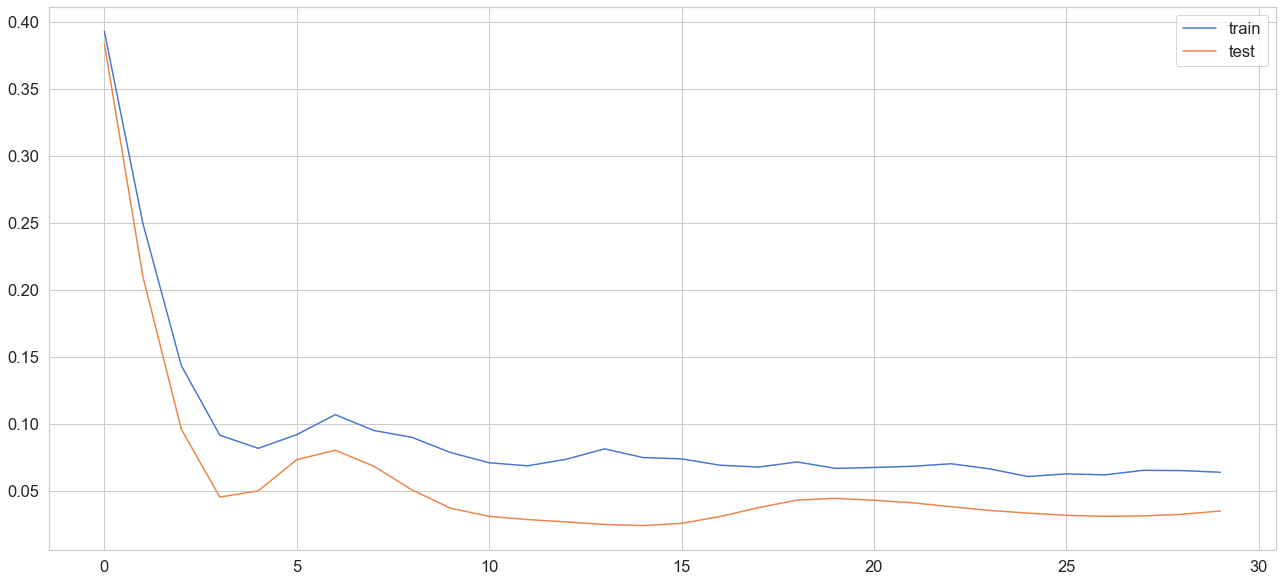

In [56]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();


In [57]:
y_predSAA = modelSAA.predict(X_test)
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_invSAA = cnt_transformer.inverse_transform(y_predSAA)

# BASELINE LSTM

In [58]:
merged_sim  = merged[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','Close']]
train_size = int(len(merged_sim) * 0.67)
test_size = len(merged_sim) - train_size
train, test = merged_sim.iloc[0:train_size], merged_sim.iloc[train_size:len(merged_sim)]
print(len(train), len(test))

73 37


In [59]:
from sklearn.preprocessing import RobustScaler

f_columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['Close']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['Close'] = cnt_transformer.transform(train[['Close']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['Close'] = cnt_transformer.transform(test[['Close']])

In [60]:
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

print(X_train.shape, y_train.shape)

(72, 1, 6) (72,)


In [61]:
modelbase = keras.Sequential()
modelbase.add(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
)
modelbase.add(keras.layers.Dropout(rate=0.2))
modelbase.add(keras.layers.Dense(units=1))
modelbase.compile(loss='mean_squared_error', optimizer='adam')

In [62]:
history = modelbase.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
2/2 [==============================] - 1s 355ms/step - loss: 0.4374 - val_loss: 0.5730
Epoch 2/30
2/2 [==============================] - 0s 40ms/step - loss: 0.3949 - val_loss: 0.5264
Epoch 3/30
2/2 [==============================] - 0s 45ms/step - loss: 0.3623 - val_loss: 0.4810
Epoch 4/30
2/2 [==============================] - 0s 46ms/step - loss: 0.3243 - val_loss: 0.4374
Epoch 5/30
2/2 [==============================] - 0s 46ms/step - loss: 0.2986 - val_loss: 0.3957
Epoch 6/30
2/2 [==============================] - 0s 47ms/step - loss: 0.2707 - val_loss: 0.3559
Epoch 7/30
2/2 [==============================] - 0s 46ms/step - loss: 0.2405 - val_loss: 0.3182
Epoch 8/30
2/2 [==============================] - 0s 44ms/step - loss: 0.2174 - val_loss: 0.2826
Epoch 9/30
2/2 [==============================] - 0s 51ms/step - loss: 0.2024 - val_loss: 0.2492
Epoch 10/30
2/2 [==============================] - 0s 44ms/step - loss: 0.1736 - val_loss: 0.2180
Epoch 11/30
2/2 [===========

In [63]:
y_predbase = modelbase.predict(X_test)
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_invbase = cnt_transformer.inverse_transform(y_predbase)

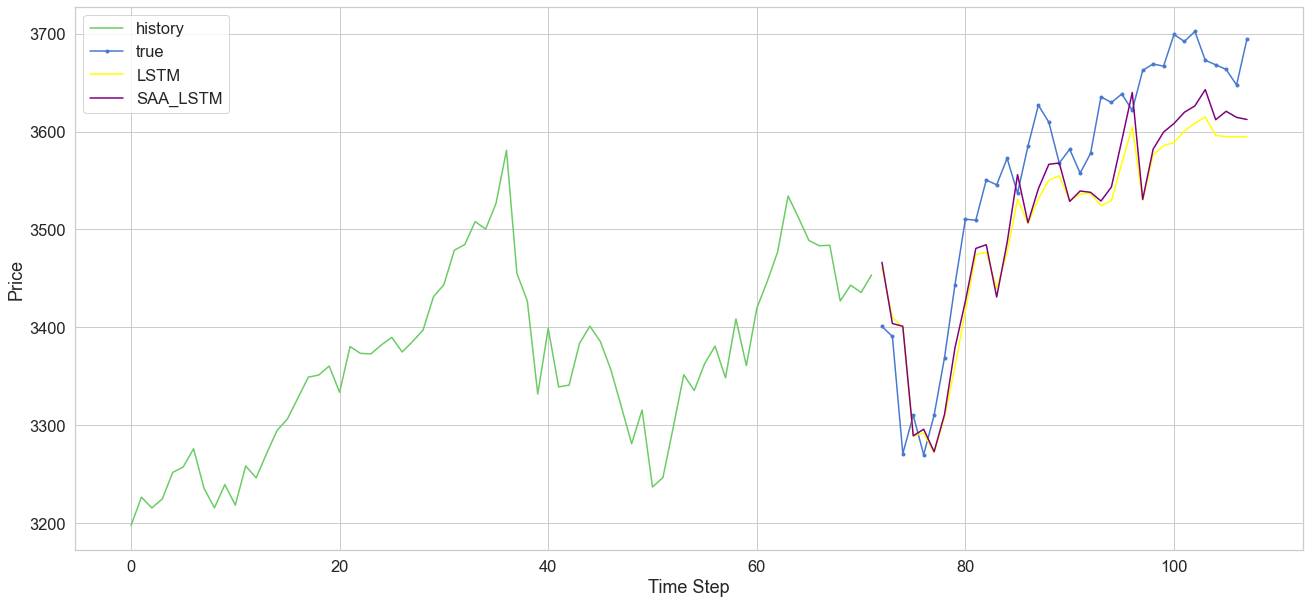

In [64]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_invbase.flatten(), 'yellow', label="LSTM")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_invSAA.flatten(), 'purple', label="SAA_LSTM")
plt.ylabel('Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

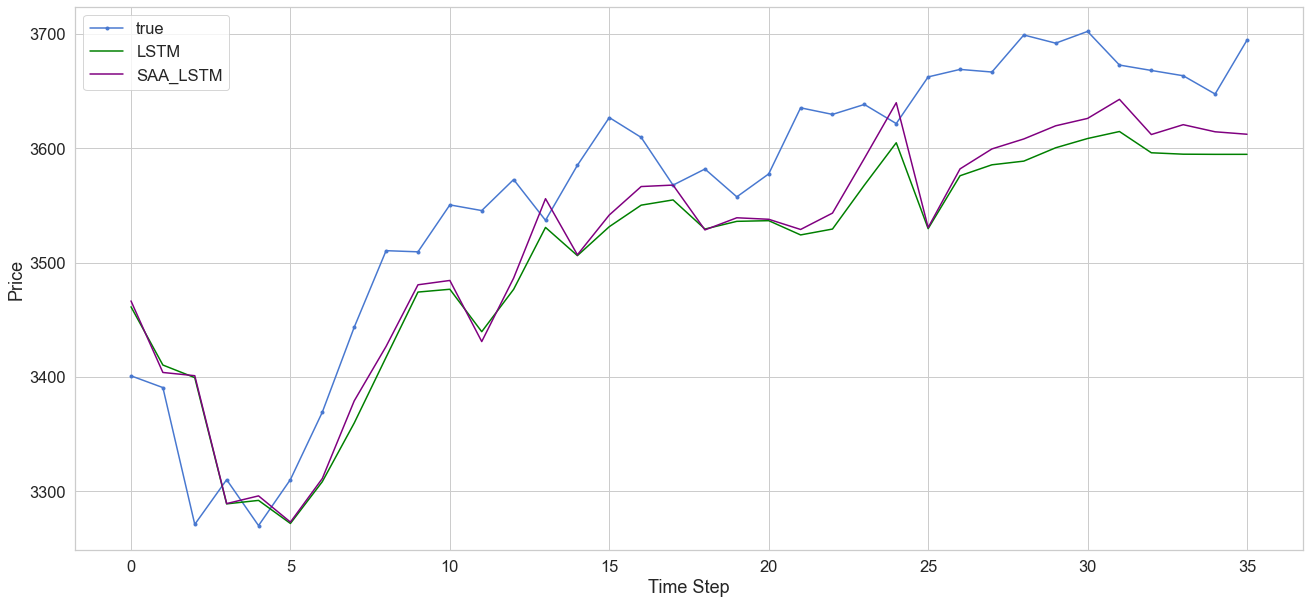

In [65]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_invbase.flatten(), 'green', label = "LSTM")
plt.plot(y_pred_invSAA.flatten(), 'purple', label="SAA_LSTM")
plt.ylabel('Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [66]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score 

#FOR BASE LSTM

rmse = np.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_invbase.flatten()))
mae = mean_absolute_error(y_test_inv.flatten(), y_pred_invbase.flatten())
r2 = r2_score(y_test_inv.flatten(), y_pred_invbase.flatten())


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_inv.flatten(), y_pred_invbase.flatten())


print('=======FOR LSTM BASELINE=======\n')
print("RMSE: " , rmse)
print("MAE: ", mae)
print("R2: ", r2)
print("MAPE: ", mape)
#FOR SAA LSTM
rmse = np.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_invSAA.flatten()))
mae = mean_absolute_error(y_test_inv.flatten(), y_pred_invSAA.flatten())
r2 = r2_score(y_test_inv.flatten(), y_pred_invSAA.flatten())


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_inv.flatten(), y_pred_invSAA.flatten())


print('=======FOR SAA_LSTM=======\n')
print("RMSE: " , rmse)
print("MAE: ", mae)
print("R2: ", r2)
print("MAPE: ", mape)


=======FOR LSTM BASELINE=======

RMSE:  76.25505678477388
MAE:  68.31561957465277
R2:  0.6407526142069663
MAPE:  1.9109563500439408
=======FOR SAA_LSTM=======

RMSE:  68.38453153976558
MAE:  59.981723361545136
R2:  0.71108368217612
MAPE:  1.6819819018912978
